Obrázek: ./data/cv08_im1.bmp
	Počet nalezených objektů: 4
	Objekt 1: (63, 30)
	Objekt 2: (229, 33)
	Objekt 3: (63, 205)
	Objekt 4: (233, 212)


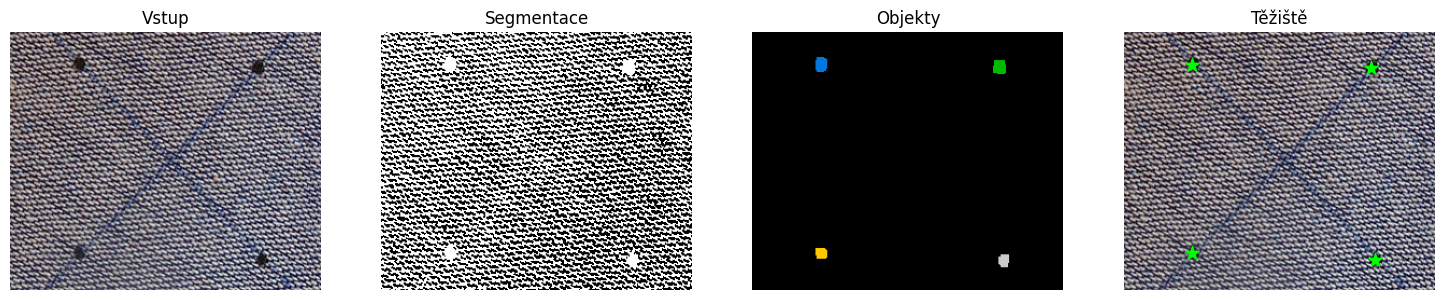

Obrázek: ./data/cv08_im2.bmp
	Počet nalezených objektů: 4
	Objekt 1: (38, 34)
	Objekt 2: (197, 34)
	Objekt 3: (197, 192)
	Objekt 4: (38, 195)


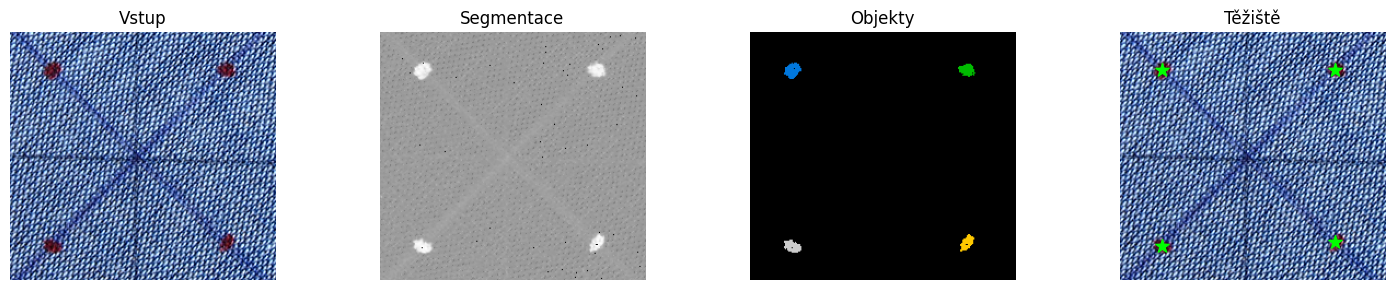

In [ ]:
# made by Martin "Granc3k" Šimon, Jakub "Parrot2" Keršláger

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


# Findne všechny objekty pomocí BFS a označí je čísly
def find_objects(bin_image):
    h, w = bin_image.shape  # width, height
    visited = np.zeros_like(bin_image, dtype=bool)  # visitnutý body
    result = np.zeros_like(bin_image, dtype=np.uint8)  # výstupní mapa
    number_of_object = 0  # čítač objektů
    direct = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # sousední pixely

    for y in range(h):
        for x in range(w):
            # If se najde označená oblast a není ve visited
            if bin_image[y, x] == 1 and not visited[y, x]:
                # increase čísla při nalezení dalšího obejktu
                number_of_object += 1
                # Kidne se to do fronty a mark na visited
                fronta = deque([(y, x)])
                visited[y, x] = True
                result[y, x] = number_of_object

                while fronta:
                    # Fronta jede a zpracováva bfs
                    i, j = fronta.popleft()
                    for dy, dx in direct:
                        # další kroky pro další průběh
                        ny, nx = i + dy, j + dx
                        if 0 <= ny < h and 0 <= nx < w:
                            # If pixekl není visited a je v bin_image 1
                            if not visited[ny, nx] and bin_image[ny, nx] == 1:
                                # Kidne se to do fronty a mark na visited
                                visited[ny, nx] = True
                                result[ny, nx] = number_of_object
                                fronta.append((ny, nx))
    return result


# Calc těžiště pro každý objekt
def calc_center(mapa_objektu):
    centers = []
    for i in range(1, mapa_objektu.max() + 1):
        mask = (mapa_objektu == i).astype(np.uint8)
        moments = cv2.moments(mask)
        if moments["m00"] > 0:
            # Calc průměrné pozice všech pixelů v objektu
            x = int(moments["m10"] / moments["m00"])
            y = int(moments["m01"] / moments["m00"])
            centers.append((x, y))
    return centers


def plot_print(path, regiony, teziste, input_image, binar):
    print(f"Obrázek: {path}")
    print(f"\tPočet nalezených objektů: {regiony.max()}")
    for idx, (x, y) in enumerate(teziste, 1):
        print(f"\tObjekt {idx}: ({x}, {y})")

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 4, 1)
    plt.imshow(input_image)
    plt.title("Vstup")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(binar, cmap="gray")
    plt.title("Segmentace")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(regiony, cmap="nipy_spectral")
    plt.title("Objekty")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(input_image)
    for x, y in teziste:
        plt.scatter(x, y, color="lime", marker="*", s=100)
    plt.title("Těžiště")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def process_image1(path, kanal=2, kernel=5):
    input_image = cv2.imread(path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Highlight blue kanálu
    data = input_image[:, :, kanal]

    # Invert na binárku
    metoda = cv2.THRESH_BINARY_INV
    _, binar = cv2.threshold(data, 0, 1, metoda + cv2.THRESH_OTSU)

    # Morfolog. operace - otevžení
    kern = np.ones((kernel, kernel), np.uint8)
    morph_filter = cv2.morphologyEx(binar, cv2.MORPH_OPEN, kern)

    # Getne objekty a calcne těžiště
    regiony = find_objects(morph_filter)
    teziste = calc_center(regiony)

    plot_print(path, regiony, teziste, input_image, binar)


def process_image2(path, kanal=0, prah=150):
    input_image = cv2.imread(path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

    # Highlight Hue kanálu
    data = input_image[:, :, kanal]
    binar = (data > prah).astype(np.uint8)

    # Getne objekty a calcne těžiště
    regiony = find_objects(binar)
    teziste = calc_center(regiony)

    input_image = cv2.cvtColor(input_image, cv2.COLOR_HSV2RGB)

    plot_print(path, regiony, teziste, input_image, data)


# Spuštění
process_image1("./data/cv08_im1.bmp", kanal=2, kernel=7)
process_image2("./data/cv08_im2.bmp", kanal=0, prah=150)